In [9]:
import dill
import os
import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon, mapping, Point
from matplotlib import pyplot as plt
from smallest_circle import *

In [10]:
class Scores:
    pass
class Circles:
    pass

In [18]:
for i in range(1,2):
    directory = './day' + str(i) + '/'
    c = Circles()
    s = Scores()
    count = 0
    for filename in os.listdir(directory):
        share, no_share, number, routes = dill.load(open(directory + filename, 'rb'))
        if number > 1:
            setattr(c, str(i) + 'c' + str(count), make_circle([point for _, _, point, _ in routes]))
            setattr(s, str(i) + 's' + str(count), (no_share - share) / number)
            count += 1
    dill.dump(c, open('day' + str(i) + '_circle.pkd', 'wb'))
    dill.dump(s, open('day' + str(i) + '_scores.pkd', 'wb'))

In [8]:
geometry_df = gp.read_file('geo_export_af57ed2a-558b-46a2-9da6-2daa495b229d.shp')
geometry_df = geometry_df.set_index('boro_name')
nybb_path = gp.datasets.get_path('nybb')
boros = gp.GeoDataFrame.from_file(nybb_path)
boros = boros.to_crs({'init': 'epsg:4326'}) 
boros = boros.set_index('BoroName')
Manhattan_geometry = boros['geometry']['Manhattan']
simplified_Manhattan_geometry = Manhattan_geometry.simplify(0.004, preserve_topology=False)

In [19]:
def plot_function(circle_dict, score_dict, sampling_number_in_Manhattan_geoemetry, plot_name):
    

# key_ls = list(zip(s.__dict__.keys(),c.__dict__.keys()))
    key_ls = list(zip(score_dict.keys(), circle_dict.keys()))

    def score_function(points):
        x_coord = [0] * len(points)
        y_coord = [0] * len(points)
        score_ls = [0] * len(points)
        for skey, ckey in key_ls:
            _score_function = lambda point: s.__dict__[skey] if is_in_circle(c.__dict__[ckey],point) else 0
            for i, point in enumerate(points):
                score_ls[i] += _score_function(point)
                x_coord[i], y_coord[i] = point
        return score_ls, x_coord, y_coord

    def random_points_in_polygon(number, polygon=simplified_Manhattan_geometry):
        points = []
        min_x, min_y, max_x, max_y = polygon.bounds
        i= 0
        while i < number:
            point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
            if polygon.contains(point):
                points.append(point)
                i += 1
        return points 
    
    
    random_point_list = random_points_in_polygon(sampling_number_in_Manhattan_geoemetry)
    random_Point_list = [mapping(point)['coordinates'] for point in random_point_list]
    scores, xcoords, ycoords = score_function(random_Point_list)
    df = pd.DataFrame({'scores': scores, 'Longitude': xcoords, 'Latitude': ycoords})
    gdf = gp.GeoDataFrame(df,  crs={'init': 'epsg:4326'}, geometry=gp.points_from_xy(df.Longitude, df.Latitude))
    
    fig, ax = plt.subplots()

    gdf.plot(ax=ax, column='scores',legend=True, cmap='binary', alpha=0.5, markersize=10)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(plot_name)
    return gdf
    

In [ ]:
gdf_list = []
for day in range(1, 8):

    c = dill.load(open('day' + str(day) + '_circle.pkd', 'rb'))
    s = dill.load(open('day' + str(day) + '_scores.pkd', 'rb'))
    
    gdf_list.append(plot_function(c.__dict__, s.__dict__, 10000, 'day' + str(day) + '_location_dependency_plot'))
    

In [28]:
dill.dump(gdf_list, open('location_dependency_gdf_list', 'wb'))
gdf = gp.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))


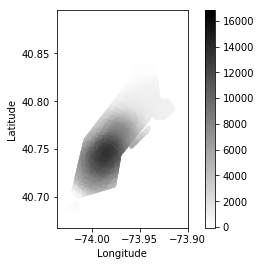

In [34]:
fig, ax = plt.subplots()
gdf.plot(ax=ax, column='scores',legend=True, cmap='binary', alpha=0.5, markersize=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('Overall_ocation_dependency_plot')

